# Import

In [11]:
# Import các thư viện cần thiết
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display
from pathlib import Path

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_style("whitegrid")


In [12]:
df_non_financial = pd.read_csv("../data/processed/fa/non_financial_data.csv")
df_financial = pd.read_csv("../data/processed/fa/financial_data.csv")

## Ranking FA

### 1. Chuẩn bị dữ liệu cho Ranking

In [45]:
# ---------------------------------------------------------
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU (CHỈ GIỮ KỲ MỚI NHẤT + CÙNG KỲ NĂM TRƯỚC)
# ---------------------------------------------------------
print("=" * 80)
print("PREPARING DATA FOR RANKING (Latest quarter snapshot + lag)")
print("=" * 80)

def get_periods_to_keep(df):
    latest_year = df['Năm'].max()
    latest_quarter = df.loc[df['Năm'] == latest_year, 'Kỳ'].max()
    periods = [(latest_year, latest_quarter)]
    prev_year = latest_year - 1
    if ((df['Năm'] == prev_year) & (df['Kỳ'] == latest_quarter)).any():
        periods.append((prev_year, latest_quarter))
    return periods

def filter_by_periods(df, periods):
    mask = pd.Series(False, index=df.index)
    for year, quarter in periods:
        mask |= ((df['Năm'] == year) & (df['Kỳ'] == quarter))
    return df[mask].copy()

# --- Phi tài chính ---
periods_non_fin = get_periods_to_keep(df_non_financial)
df_recent_non_fin = filter_by_periods(df_non_financial, periods_non_fin)
if 'CP' in df_recent_non_fin.columns:
    df_recent_non_fin = df_recent_non_fin.rename(columns={'CP': 'symbol'})
df_recent_non_fin['is_financial'] = 0

# --- Tài chính ---
periods_fin = get_periods_to_keep(df_financial)
df_recent_fin = filter_by_periods(df_financial, periods_fin)
if 'CP' in df_recent_fin.columns:
    df_recent_fin = df_recent_fin.rename(columns={'CP': 'symbol'})
df_recent_fin['is_financial'] = 1

# --- Gộp dữ liệu ---
df_recent = pd.concat([df_recent_non_fin, df_recent_fin], ignore_index=True)

def periods_to_text(periods):
    return [f"{year}_Q{quarter}" for year, quarter in periods]

print(f"\n✓ Non-financial periods kept: {periods_to_text(periods_non_fin)}")
print(f"✓ Financial periods kept: {periods_to_text(periods_fin)}")
print(f"✓ Dataset size: {df_recent.shape[0]:,} rows")
print(f"✓ Unique stocks: {df_recent['symbol'].nunique()}")

display(df_recent.head(10))

PREPARING DATA FOR RANKING (Latest quarter snapshot + lag)

✓ Non-financial periods kept: ['2025_Q3', '2024_Q3']
✓ Financial periods kept: ['2025_Q3', '2024_Q3']
✓ Dataset size: 2,258 rows
✓ Unique stocks: 1151


,symbol,Năm,Kỳ,TÀI SẢN NGẮN HẠN (đồng),Tiền và tương đương tiền (đồng),Giá trị thuần đầu tư ngắn hạn (đồng),Các khoản phải thu ngắn hạn (đồng),Hàng tồn kho ròng,Tài sản lưu động khác,TÀI SẢN DÀI HẠN (đồng),...,ROA,ROE,Current_Ratio,D_E_Ratio,Inventory_Turnover,year_quarter,Capital_Ratio,Provision_Ratio,NIM_Proxy,LDR
0,AAA,2025,3,4377037083396.0000,1741373916584,186400000000.0000,1531251902335.0000,757283181389.0000,160728083088.0000,7864700594492.0000,...,0.0102,0.0208,1.4071,1.0342,2.6699,2025_Q3,NaN,NaN,NaN,NaN
1,AAA,2024,3,6956714508528.0000,1945532019980,1346697394178.0000,2303218872955.0000,1138806271275.0000,222459950140.0000,6075525235098.0000,...,-0.0020,-0.0042,1.6818,1.1447,2.5009,2024_Q3,NaN,NaN,NaN,NaN
2,AAH,2025,3,513107950491.0000,938415718,0.0000,471659636563.0000,38641967572.0000,1867930638.0000,1023294960315.0000,...,0.0000,0.0001,1.5399,0.2777,6.1292,2025_Q3,NaN,NaN,NaN,NaN
3,AAH,2024,3,478151250786.0000,9680694498,0.0000,403203392832.0000,65267163456.0000,0.0000,949063982645.0000,...,0.0036,0.0043,2.0340,0.1986,4.9169,2024_Q3,NaN,NaN,NaN,NaN
4,AAM,2025,3,169314740115.0000,97287937010,42000039920.0000,4615241415.0000,19945551663.0000,5465970107.0000,34526458875.0000,...,0.0020,0.0020,46.5379,0.0239,1.9007,2025_Q3,NaN,NaN,NaN,NaN
5,AAM,2024,3,174016585714.0000,51706572075,39920.0000,10885566911.0000,106907086958.0000,4517319850.0000,37480258917.0000,...,-0.0060,-0.0064,13.7899,0.0699,0.4406,2024_Q3,NaN,NaN,NaN,NaN
6,AAS,2025,3,4172986076953.0000,249781432074,1577993219820.0000,2344073433446.0000,0.0000,1137991613.0000,267333922008.0000,...,0.0253,0.0423,2.4572,0.6734,0.0000,2025_Q3,NaN,NaN,NaN,NaN
7,AAS,2024,3,3479244870602.0000,55916366023,1026670452736.0000,2395943993223.0000,0.0000,714058620.0000,233315431873.0000,...,0.0043,0.0064,3.4080,0.4894,0.0000,2024_Q3,NaN,NaN,NaN,NaN
8,AAT,2025,3,450849537219.0000,11497944127,25143285184.0000,375745107176.0000,23952953294.0000,14510247438.0000,977253209400.0000,...,0.0050,0.0096,1.3886,0.9089,8.3050,2025_Q3,NaN,NaN,NaN,NaN
9,AAT,2024,3,531482320572.0000,39026675061,25047188076.0000,459190208449.0000,8095190027.0000,123058959.0000,615565975197.0000,...,0.0021,0.0033,1.9028,0.6009,6.4031,2024_Q3,NaN,NaN,NaN,NaN


### 2. Tính điểm tổng và Ranking

In [46]:
def score_stocks_scientifically(df):
    df = df.copy()
    
    # 1. Chuẩn hoá tên cột symbol
    if 'symbol' not in df.columns and 'CP' in df.columns:
        df = df.rename(columns={'CP': 'symbol'})
    
    # 2. Định nghĩa danh sách cột cần lấy dữ liệu quá khứ
    cols_check = [
        'symbol', 'Năm', 'Kỳ', 
        'ROA', 
        'Lưu chuyển tiền tệ ròng từ các hoạt động SXKD',
        'Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng)',
        'Nợ dài hạn (đồng)', 'TỔNG CỘNG TÀI SẢN (đồng)',
        'TÀI SẢN NGẮN HẠN (đồng)', 'Nợ ngắn hạn (đồng)',
        'Vốn góp của chủ sở hữu (đồng)',
        'Lãi gộp', 'Doanh thu thuần',
        'ROE', 'Capital_Ratio', 'Provision_Ratio', 'NIM_Proxy', 'LDR'
    ]
    available_cols = [c for c in cols_check if c in df.columns]
    
    # 3. Tạo dữ liệu quá khứ (_prev)
    df_curr = df.sort_values(by=['symbol', 'Năm', 'Kỳ'])
    df_curr['Prev_Year'] = df_curr['Năm'] - 1
    df_prev = df_curr[available_cols].copy()
    rename_map = {c: c + '_prev' for c in available_cols if c not in ['symbol', 'Năm', 'Kỳ']}
    rename_map['Năm'] = 'Prev_Year'
    df_prev = df_prev.rename(columns=rename_map)
    merged = pd.merge(df_curr, df_prev, on=['symbol', 'Prev_Year', 'Kỳ'], how='left')
    
    def safe_div(a, b):
        return np.where(b == 0, 0, a / b)

    # --- PHẦN 1: PIOTROSKI F-SCORE ---
    for col in available_cols:
        if col in merged.columns:
            merged[col] = merged[col].fillna(0)
            if f'{col}_prev' in merged.columns:
                merged[f'{col}_prev'] = merged[f'{col}_prev'].fillna(0)

    merged['F1'] = (merged['ROA'] > 0).astype(int)
    cfo_col = 'Lưu chuyển tiền tệ ròng từ các hoạt động SXKD'
    if cfo_col in merged.columns:
        merged['F2'] = (merged[cfo_col] > 0).astype(int)
        ni_col = 'Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng)'
        if ni_col in merged.columns:
             merged['F4'] = (merged[cfo_col] > merged[ni_col]).astype(int)
        else:
             merged['F4'] = 0
    else:
        merged['F2'] = 0
        merged['F4'] = 0
    if 'ROA_prev' in merged.columns:
        merged['F3'] = (merged['ROA'] > merged['ROA_prev']).astype(int)
    else:
        merged['F3'] = 0
    ltd_col = 'Nợ dài hạn (đồng)'
    asset_col = 'TỔNG CỘNG TÀI SẢN (đồng)'
    if ltd_col in merged.columns and f'{ltd_col}_prev' in merged.columns:
        lev_curr = safe_div(merged[ltd_col], merged[asset_col])
        lev_prev = safe_div(merged[f'{ltd_col}_prev'], merged[f'{asset_col}_prev'])
        merged['F5'] = (lev_curr < lev_prev).astype(int)
    else: 
        merged['F5'] = 0
    ca_col = 'TÀI SẢN NGẮN HẠN (đồng)'
    cl_col = 'Nợ ngắn hạn (đồng)'
    if ca_col in merged.columns and f'{ca_col}_prev' in merged.columns:
        cr_curr = safe_div(merged[ca_col], merged[cl_col])
        cr_prev = safe_div(merged[f'{ca_col}_prev'], merged[f'{cl_col}_prev'])
        merged['F6'] = (cr_curr > cr_prev).astype(int)
    else:
        merged['F6'] = 0
    eq_col = 'Vốn góp của chủ sở hữu (đồng)'
    if eq_col in merged.columns and f'{eq_col}_prev' in merged.columns:
        merged['F7'] = (merged[eq_col] <= merged[f'{eq_col}_prev']).astype(int)
    else:
        merged['F7'] = 0
    gp_col = 'Lãi gộp'
    rev_col = 'Doanh thu thuần'
    if gp_col in merged.columns and f'{gp_col}_prev' in merged.columns:
        gpm_curr = safe_div(merged[gp_col], merged[rev_col])
        gpm_prev = safe_div(merged[f'{gp_col}_prev'], merged[f'{rev_col}_prev'])
        merged['F8'] = (gpm_curr > gpm_prev).astype(int)
    else:
        merged['F8'] = 0
    if rev_col in merged.columns and f'{rev_col}_prev' in merged.columns:
        at_curr = safe_div(merged[rev_col], merged[asset_col])
        at_prev = safe_div(merged[f'{rev_col}_prev'], merged[f'{asset_col}_prev'])
        merged['F9'] = (at_curr > at_prev).astype(int)
    else:
        merged['F9'] = 0
    merged['Piotroski_Score'] = merged[['F1','F2','F3','F4','F5','F6','F7','F8','F9']].sum(axis=1)

    # --- PHẦN 2: BANK SCORE (Chỉ tính cho is_financial==1) ---
    merged['Bank_Score'] = 0.0
    try:
        bank_cols = ['Capital_Ratio', 'Provision_Ratio', 'NIM_Proxy', 'LDR', 'ROA', 'ROE']
        missing_cols = [col for col in bank_cols if col not in merged.columns]
        if missing_cols:
            print(f"⚠️ Missing bank columns: {missing_cols}")
        
        # Chỉ tính Bank_Score cho các dòng is_financial==1 và đủ cột
        if all(col in merged.columns for col in bank_cols):
            bank_mask = merged['is_financial'] == 1
            merged.loc[~bank_mask, ['Score_Cap','Score_Asset','Score_Earn','Score_Liq']] = np.nan
            merged.loc[bank_mask, 'Score_Cap'] = merged[bank_mask].groupby(['Năm', 'Kỳ'])['Capital_Ratio'].rank(pct=True)
            merged.loc[bank_mask, 'Score_Asset'] = merged[bank_mask].groupby(['Năm', 'Kỳ'])['Provision_Ratio'].rank(pct=True, ascending=False)
            merged.loc[bank_mask, 'Score_Earn'] = (
                merged[bank_mask].groupby(['Năm', 'Kỳ'])['ROA'].rank(pct=True) + 
                merged[bank_mask].groupby(['Năm', 'Kỳ'])['ROE'].rank(pct=True) + 
                merged[bank_mask].groupby(['Năm', 'Kỳ'])['NIM_Proxy'].rank(pct=True)
            ) / 3
            merged.loc[bank_mask, 'Score_Liq'] = merged[bank_mask].groupby(['Năm', 'Kỳ'])['LDR'].rank(pct=True, ascending=False)
            merged.loc[bank_mask, 'Bank_Score'] = (0.2*merged.loc[bank_mask, 'Score_Cap'] + 0.2*merged.loc[bank_mask, 'Score_Asset'] + 0.4*merged.loc[bank_mask, 'Score_Earn'] + 0.2*merged.loc[bank_mask, 'Score_Liq']) * 10
            # Đảm bảo non-financial luôn là 0
            merged.loc[~bank_mask, 'Bank_Score'] = 0.0
            # --- SCALE BANK SCORE: max = 10 ---
            # Scale theo từng kỳ (Năm, Kỳ) để mỗi kỳ đều có max = 10
            for (y, q), idxs in merged[bank_mask].groupby(['Năm', 'Kỳ']).groups.items():
                max_bank = merged.loc[idxs, 'Bank_Score'].max()
                if pd.notnull(max_bank) and max_bank > 0:
                    merged.loc[idxs, 'Bank_Score'] = merged.loc[idxs, 'Bank_Score'] / max_bank * 10
    except Exception as e:
        print(f"Lỗi tính Bank Score: {e}")

    # --- PHẦN 3: FINAL SCORE ---
    merged['Scientific_Score'] = np.where(
        merged['is_financial'] == 1,
        merged['Bank_Score'],
        (merged['Piotroski_Score'] / 9) * 10
    )
    
    return merged.sort_values('Scientific_Score', ascending=False)

In [52]:
ranked_stocks = score_stocks_scientifically(df_recent)
def get_top_100_current_stocks(df_ranked):
    df = df_ranked.copy()
    
    # BƯỚC 1: Lấy dữ liệu mới nhất của từng mã
    # Sắp xếp theo Mã và Thời gian giảm dần (Năm giảm, Kỳ giảm)
    df = df.sort_values(by=['symbol', 'Năm', 'Kỳ'], ascending=[True, False, False])
    
    # Drop duplicates theo 'symbol', giữ lại dòng đầu tiên (chính là kỳ mới nhất)
    df_latest = df.drop_duplicates(subset=['symbol'], keep='first')
    
    # BƯỚC 2: Xử lý trường hợp bằng điểm (Tie-breaker)
    # Vì Piotroski là số nguyên (7, 8, 9) nên sẽ có rất nhiều mã bằng điểm nhau.
    # Ta cần tiêu chí phụ để xếp hạng. Ưu tiên:
    # 1. Scientific_Score (Điểm tổng hợp)
    # 2. ROA (Hiệu quả sinh lời - ưu tiên cái nào làm ra tiền tốt hơn)
    # 3. ROE (Hiệu quả vốn chủ)
    
    df_latest = df_latest.sort_values(
        by=['Scientific_Score', 'ROA', 'ROE'], 
        ascending=[False, False, False]
    )
    
    # BƯỚC 3: Lấy Top 100
    top_100 = df_latest.head(100).reset_index(drop=True)
    
    # Thêm cột Rank
    top_100['Rank'] = top_100.index + 1
    
    return top_100

# --- CHẠY VÀ HIỂN THỊ ---
final_top_100 = get_top_100_current_stocks(ranked_stocks)

print("🏆 FINAL TOP 100 STOCKS (Snapshot mới nhất):")
# Chọn các cột quan trọng để hiển thị
cols_display = [
    'Rank', 'symbol', 'is_financial', 'Scientific_Score', 
    'Piotroski_Score', 'Bank_Score', 
    'Năm', 'Kỳ', 'ROA', 'ROE'
]

display(final_top_100[cols_display])

🏆 FINAL TOP 100 STOCKS (Snapshot mới nhất):


,Rank,symbol,is_financial,Scientific_Score,Piotroski_Score,Bank_Score,Năm,Kỳ,ROA,ROE
0,1,PDB,0,10.0000,9,0.0000,2025,3,0.0896,0.1301
1,2,HPD,0,10.0000,9,0.0000,2025,3,0.0591,0.0754
2,3,KSV,0,10.0000,9,0.0000,2025,3,0.0577,0.1196
3,4,VNM,0,10.0000,9,0.0000,2025,3,0.0451,0.0661
4,5,OGC,0,10.0000,9,0.0000,2025,3,0.0404,0.1028
...,...,...,...,...,...,...,...,...,...,...
95,96,TMC,0,8.8889,8,0.0000,2025,3,0.0075,0.0152
96,97,XMP,0,8.8889,8,0.0000,2025,3,0.0074,0.0153
97,98,TNW,0,8.8889,8,0.0000,2025,3,0.0071,0.0281
98,99,KSB,0,8.8889,8,0.0000,2025,3,0.0070,0.0129


### 5. Visualization - Score Distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


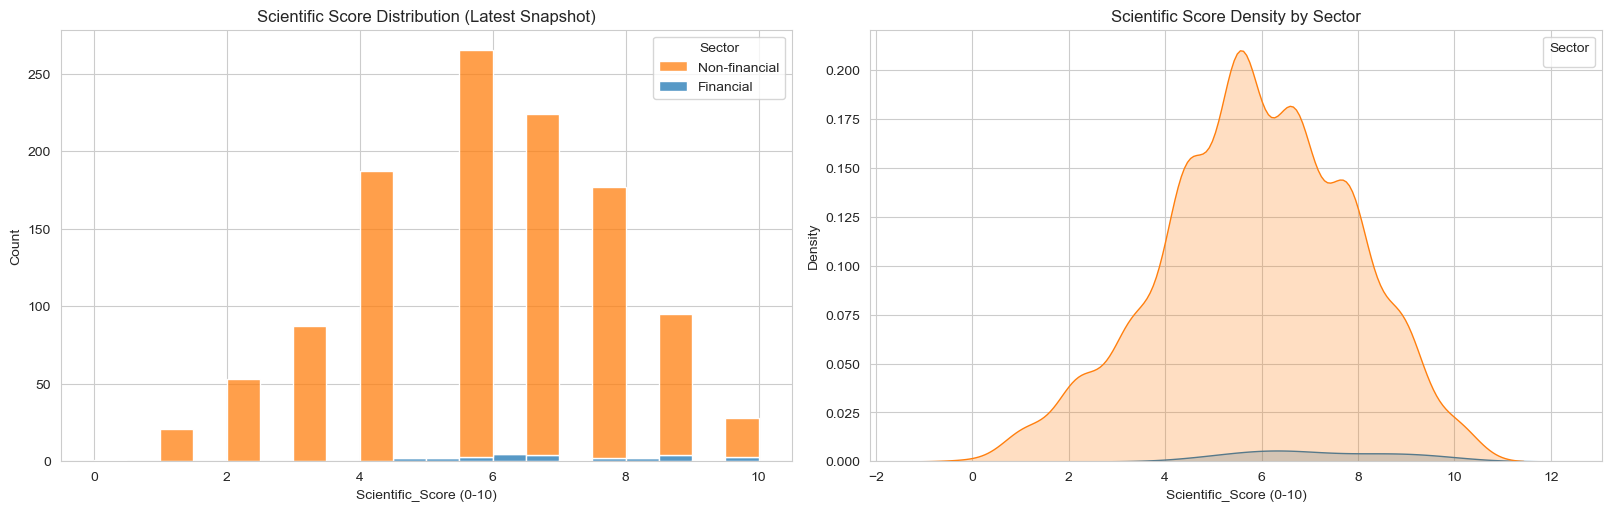

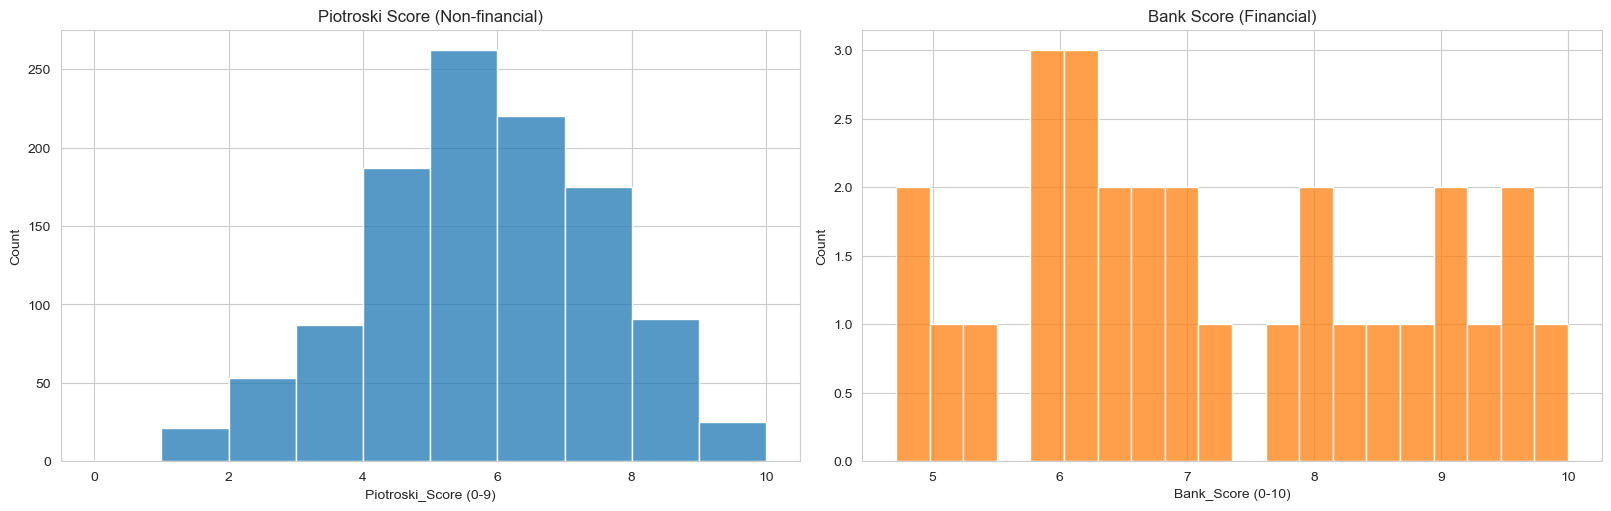

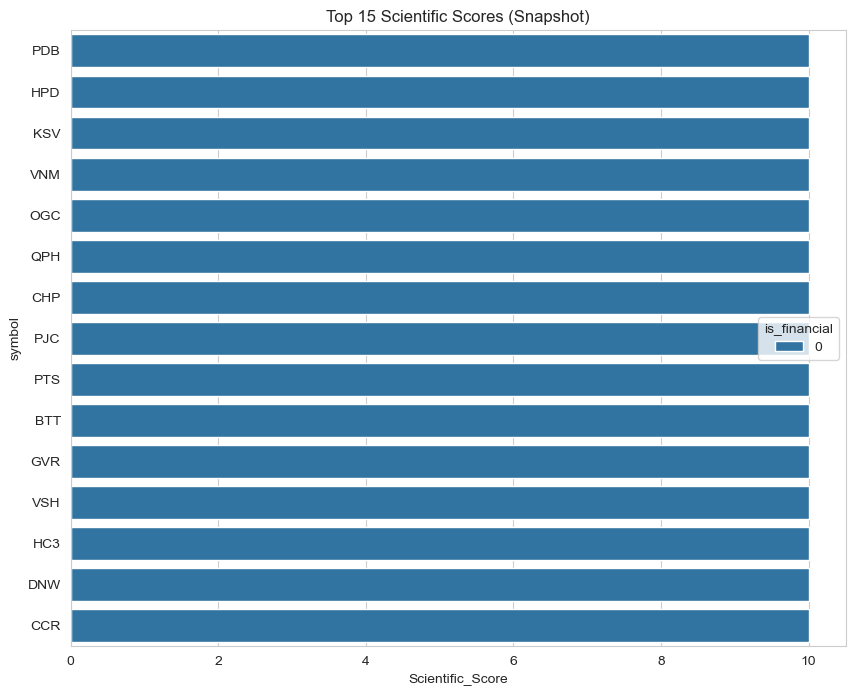

In [53]:
# Visualization helpers
if 'ranked_stocks' not in locals():
    print('⚠️ Vui lòng chạy lại bước tính điểm trước khi visualize.')
else:
    latest_snapshot = (
        ranked_stocks
        .sort_values(by=['symbol', 'Năm', 'Kỳ'], ascending=[True, False, False])
        .drop_duplicates(subset=['symbol'], keep='first')
        .copy()
    )
    latest_snapshot['Sector'] = np.where(latest_snapshot['is_financial'] == 1, 'Financial', 'Non-financial')

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    sns.histplot(
        data=latest_snapshot,
        x='Scientific_Score',
        hue='Sector',
        multiple='stack',
        bins=20,
        ax=axes[0],
        palette=['#ff7f0e', '#1f77b4'],
        edgecolor='white'
    )
    axes[0].set_title('Scientific Score Distribution (Latest Snapshot)')
    axes[0].set_xlabel('Scientific_Score (0-10)')

    sns.kdeplot(
        data=latest_snapshot,
        x='Scientific_Score',
        hue='Sector',
        fill=True,
        alpha=0.25,
        ax=axes[1],
        palette=['#ff7f0e', '#1f77b4']
    )
    axes[1].set_title('Scientific Score Density by Sector')
    axes[1].set_xlabel('Scientific_Score (0-10)')
    axes[1].legend(title='Sector')

    non_fin = latest_snapshot[latest_snapshot['is_financial'] == 0]
    fin = latest_snapshot[latest_snapshot['is_financial'] == 1]

    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    if non_fin.empty:
        axes2[0].text(0.5, 0.5, 'Không có dữ liệu phi tài chính', ha='center', va='center')
        axes2[0].set_axis_off()
    else:
        sns.histplot(
            data=non_fin,
            x='Piotroski_Score',
            bins=range(0, 11),
            ax=axes2[0],
            color='#1f77b4',
            edgecolor='white'
        )
        axes2[0].set_title('Piotroski Score (Non-financial)')
        axes2[0].set_xlabel('Piotroski_Score (0-9)')

    if fin.empty:
        axes2[1].text(0.5, 0.5, 'Không có dữ liệu ngân hàng', ha='center', va='center')
        axes2[1].set_axis_off()
    else:
        sns.histplot(
            data=fin,
            x='Bank_Score',
            bins=20,
            ax=axes2[1],
            color='#ff7f0e',
            edgecolor='white'
        )
        axes2[1].set_title('Bank Score (Financial)')
        axes2[1].set_xlabel('Bank_Score (0-10)')

    if 'final_top_100' in locals() and not final_top_100.empty:
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        top15 = final_top_100.head(15).sort_values('Scientific_Score', ascending=True)
        sns.barplot(
            data=top15,
            x='Scientific_Score',
            y='symbol',
            hue='is_financial',
            palette=['#1f77b4', '#ff7f0e'],
            ax=ax3
        )
        ax3.set_title('Top 15 Scientific Scores (Snapshot)')
        ax3.set_xlabel('Scientific_Score')
        ax3.set_ylabel('symbol')
        ax3.legend(title='is_financial')
    else:
        print('⚠️ Chưa có bảng final_top_100 để hiển thị Top 15.')

### 6. Export Top 100 Stocks

In [54]:
# Xuất ra top 100
output_path = Path("../data/raw/top_100_stocks.csv")
final_top_100.to_csv(output_path, index=False)
# Lưu kết quả ra file CSV
print(f"✓ Top 100 stocks saved to: {output_path.resolve()}")


✓ Top 100 stocks saved to: D:\Personal\Ky_VII\IntroDS\hcmus-introds--final-project\data\raw\top_100_stocks.csv
